# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
!pip install -q tqdm

import nltk
nltk.download('stopwords')

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import re
import numpy as np
import os
import time
import json
import glob
import pickle

from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from collections import Counter
from tqdm import tqdm
from PIL import Image

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Import the dataset and read the image into a seperate variable

images='Flickr8K/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

# Read caption file
captions_txt = open("Flickr8K/captions.txt", 'rb').read().decode('utf-8')
img_cap_corpus=captions_txt.split('\n')
img_cap_corpus.pop(0)

The total images present in the dataset: 8091


'image,caption'

In [3]:
# Create dictionary of image and its captions
img_cap_dic={}
for line in img_cap_corpus:   
    img_cap = line.split(',')
    
    if(len(img_cap)>=2):
    
        img_id=img_cap[0]
        caption=img_cap[1]

        if img_id not in img_cap_dic:
            img_cap_dic[img_id] = [caption]
        else:
            img_cap_dic[img_id].append(caption)

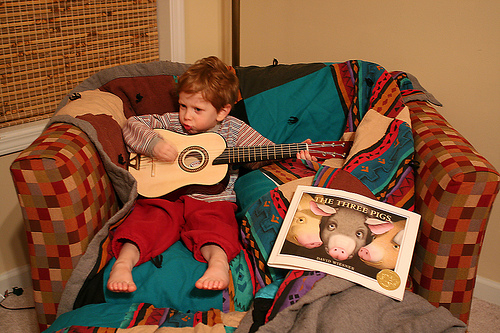

In [4]:
#Visualise both the images & text present in the dataset
Image.open(all_imgs[0])

In [5]:
# Captions for above image
img_cap_dic[all_imgs[0].split('/')[-1]]

["A boy is sitting on a brightly colored chair next to a child 's book playing a guitar .",
 'A toddler is sitting on a red checked chair whilst playing a guitar .',
 'A young child is sitting in a colorful chair with a guitar in his hands and a book sitting next to him .',
 'A young child playing guitar on the chair',
 'Young barefoot boy playing a guitar setting in a large muti colored chair with a picture of three pigs beside him .']

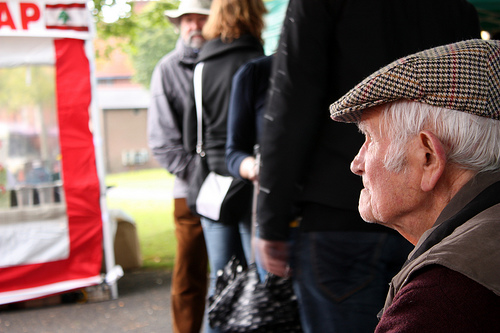

In [6]:
# Visualise another image & it's text present in the dataset
Image.open(all_imgs[-1])

In [7]:
# Captions for above image
img_cap_dic[all_imgs[-1].split('/')[-1]]

['An older man sits and several people stand .',
 'An old man in a hat sits and looks straight ahead .',
 'An old man looks at people shopping .',
 'an old man wearing a hat sitting staring off into the distance .',
 'This is a profile shot of an old man in a newspaper boy hat with people blurred out in the background .']

In [8]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    dataset = pd.read_csv(filename)
    return dataset

text_file = "Flickr8K/captions.txt"
doc = load_doc(text_file)
print(doc.shape)
print(doc[:300])
doc.head()

(40455, 2)
                         image  \
0    1000268201_693b08cb0e.jpg   
1    1000268201_693b08cb0e.jpg   
2    1000268201_693b08cb0e.jpg   
3    1000268201_693b08cb0e.jpg   
4    1000268201_693b08cb0e.jpg   
..                         ...   
295  1077546505_a4f6c4daa9.jpg   
296  1077546505_a4f6c4daa9.jpg   
297  1077546505_a4f6c4daa9.jpg   
298  1077546505_a4f6c4daa9.jpg   
299  1077546505_a4f6c4daa9.jpg   

                                               caption  
0    A child in a pink dress is climbing up a set o...  
1                A girl going into a wooden building .  
2     A little girl climbing into a wooden playhouse .  
3    A little girl climbing the stairs to her playh...  
4    A little girl in a pink dress going into a woo...  
..                                                 ...  
295  A boy in blue shorts slides down a slide into ...  
296  A boy in blue swimming trunks slides down a ye...  
297  A boy rides down a slide into a small backyard...  
298  A boy

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [9]:
all_img_id = doc.image #store all the image id here
all_img_vector = ['Flickr8K/Images/' + el for el in all_img_id] #store all the image path here
annotations= doc.caption #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 

df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [10]:
#Create the vocabulary & the counter for the captions

stop_words = stopwords.words('english')
stop_words.extend(['.', ','])
vocabulary= [word.lower() for sent in list(df.Captions) for word in sent.split() if word.lower() not in stop_words]
val_count=Counter(vocabulary)
val_count

Counter({'child': 1545,
         'pink': 735,
         'dress': 348,
         'climbing': 502,
         'set': 108,
         'stairs': 109,
         'entry': 1,
         'way': 50,
         'girl': 3328,
         'going': 149,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'spotted': 37,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
         'street': 943,
         'two': 5638,
         'dogs': 2125,
         'different': 45,
         'breeds': 5,
         'looking': 742,
         'pavement': 48,
         'moving': 41,
         'toward': 146,
         'covered': 306,
         'paint': 61,
         'sits': 577,
         'front': 1386,
         'painted': 63,
         'rainbow': 22,
         'hands': 246,
        

In [11]:
#Visualise the top 30 occuring words in the captions
val_count.most_common(30)

[('dog', 8136),
 ('man', 7265),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('woman', 3402),
 ('girl', 3328),
 ('wearing', 3062),
 ('people', 2883),
 ('water', 2783),
 ('red', 2672),
 ('young', 2630),
 ('brown', 2563),
 ('blue', 2268),
 ('dogs', 2125),
 ('running', 2073),
 ('playing', 2008),
 ('shirt', 1806),
 ('standing', 1787),
 ('ball', 1779),
 ('little', 1768),
 ('grass', 1622),
 ('child', 1545),
 ('person', 1542),
 ('snow', 1492),
 ('jumping', 1472),
 ('front', 1386),
 ('three', 1381),
 ('sitting', 1368)]

In [12]:
#Create a list which contains all the captions
annotations = [cap for cap in df['Captions']]

#add the <start> & <end> token to all those captions as well
annotations = ['<start> ' + caption.lower() + '<end>' for caption in annotations]

#Create a list which contains all the path to the images
all_img_path = df.ID.unique()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [13]:
# create the tokenizer

limit = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=limit, oov_token="UNK",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
text_to_seq = tokenizer.texts_to_sequences(annotations)

In [14]:
# Create word-to-index and index-to-word mappings.

word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word

In [15]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

tokenized_vocab = [word for sent in text_to_seq for word in sent]
tokenized_val_count = Counter(tokenized_vocab)
tokenized_val_count.most_common(30)

[(2, 62987),
 (3, 40455),
 (4, 36609),
 (5, 18983),
 (6, 18418),
 (7, 10725),
 (8, 9345),
 (9, 8862),
 (10, 8101),
 (11, 7765),
 (12, 7266),
 (13, 6722),
 (14, 5642),
 (1, 4973),
 (15, 3957),
 (16, 3845),
 (17, 3579),
 (18, 3504),
 (19, 3397),
 (20, 3322),
 (21, 3175),
 (22, 3062),
 (23, 2915),
 (24, 2877),
 (25, 2691),
 (26, 2658),
 (27, 2630),
 (28, 2578),
 (29, 2432),
 (30, 2357)]

In [16]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

text_to_seq = tokenizer.texts_to_sequences(annotations)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(text_to_seq, padding='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [17]:
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [18]:
df['Captions'] = list(cap_vector)
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,"[3, 2, 43, 5, 2, 91, 172, 8, 118, 52, 2, 406, ..."
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,"[3, 2, 20, 312, 65, 2, 195, 121, 4, 0, 0, 0, 0..."
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,"[3, 2, 40, 20, 118, 65, 2, 195, 3118, 4, 0, 0,..."
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,"[3, 2, 40, 20, 118, 6, 413, 21, 61, 3118, 4, 0..."
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,"[3, 2, 40, 20, 5, 2, 91, 172, 312, 65, 2, 195,..."


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [19]:
train_data, test_data = train_test_split(df, test_size=0.20, random_state=42)

print('training data shape: ', train_data.shape)
print('test data shape: ', test_data.shape)

training data shape:  (32364, 3)
test data shape:  (8091, 3)


In [20]:
BATCH_SIZE = 10
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

print('total number of training images : ',len(train_data.Path))
print('total number of captions for training : ',len(train_data.Captions))

total number of training images :  32364
total number of captions for training :  32364


In [21]:
def load_images(path, captions):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3)
    
    # Resize them into the shape of (299, 299)
    img = tf.image.resize(img,(299,299))
    
    # Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, captions

# create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((list(train_data.Path),list(train_data.Captions)))

# Apply load_images function as Tensor of paths and caption is being passed and then function returned the processed image and captions as it is.
train_dataset = train_dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#Shffling the data and making it available in the Batches

# Shuffle training dataset
train_dataset = train_dataset.shuffle(
    buffer_size=BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

# create test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((list(test_data.Path), list(test_data.Captions)))
test_dataset = test_dataset.map(load_images, num_parallel_calls=AUTOTUNE)

# Shuffle test dataset
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

In [22]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(10, 299, 299, 3)
(10, 39)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [23]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87916544/87910968 [==============================] - 1s 0us/step


In [24]:
# write your code to extract features from each image in the dataset
def extract_features_from_inceptionV3(image, cap):
    batch_features = image_features_extract_model(image)
    final_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    return final_features, cap

train_dataset = train_dataset.map(extract_features_from_inceptionV3, num_parallel_calls=AUTOTUNE)

In [25]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(10, 64, 2048)
(10, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [26]:
embedding_dim = 256 
units = 512
vocab_size = 5000 + 1
train_num_steps = len(train_data) // BATCH_SIZE
test_num_steps = len(test_data) // BATCH_SIZE

### Encoder

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embedding_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features)
        features = tf.nn.relu(features)  # extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [28]:
encoder=Encoder(embedding_dim)

### Attention model

In [29]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                     self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)

        return context_vector, attention_weights

### Decoder

In [30]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [31]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [32]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predictions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (10, 64, 256)
Predictions shape from Decoder: (10, 5001)
Attention weights shape from Decoder: (10, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [33]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') #define your loss object

In [34]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [35]:
checkpoint_path = "checkpoints/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [36]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [37]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [38]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [39]:
def test_loss_cal(test_dataset):
    total_loss = 0
    
    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss = total_loss / test_num_steps
        
    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [40]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id]) #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
    return final_caption



In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=#set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)